In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat.textstat import *
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np



In [2]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.WordNetLemmatizer()

In [3]:
df_consp = pd.read_csv(f'./data/conspiracy_submissions_filtered.csv', compression='gzip')
df_consp['label'] = 0

In [4]:
df_science = pd.read_csv(f'./data/worldnews_submissions_filtered.csv', compression='gzip')
df_science['label'] = 1
df_science
df = pd.concat([df_consp, df_science], axis=0)


In [5]:
submissions = df.title.values

In [6]:
def preprocessing(text):
    text = str(text)
    text = text.lower()
    return re.sub(r"(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|^&gt;","",text)

def tokenize(text):
    text = re.sub(r"[^0-9A-Za-z' \t]","",text)
    text = tokenizer.tokenize(text)
    text = [lemmatizer.lemmatize(word, pos="v") for word in text]
    return text



In [7]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing,
            tokenizer=tokenize,
            stop_words=nltk.corpus.stopwords.words('english'),
            ngram_range=(1,3),
            max_features=15000)
tfidf = tfidf_vectorizer.fit_transform(submissions).toarray()


C:\Users\isoma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  warnings.warn(


In [8]:
SentimentAnalyzer = SentimentIntensityAnalyzer()
sentiments = []
for comment in submissions:
    sentiment = SentimentAnalyzer.polarity_scores(comment)
    sentiments.append([sentiment['pos'], sentiment['neg']])



In [9]:
reddit_features = df[['num_comments']].to_numpy()
reddit_features

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int64)

In [10]:
features = np.concatenate([tfidf, sentiments, reddit_features], axis=1)
features

array([[0.   , 0.   , 0.   , ..., 0.   , 0.182, 1.   ],
       [0.   , 0.   , 0.   , ..., 0.301, 0.   , 1.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.339, 1.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.201, 0.129, 1.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.268, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [11]:
X = pd.DataFrame(features)
y = df['label'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression(class_weight='balanced', multi_class='ovr', penalty='l2', C=0.01, random_state=42).fit(X_train, y_train)

y_predict = model.predict(X_test)

rep = classification_report(y_test, y_predict)

print(rep)


              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1392
           1       0.96      0.83      0.89      2844

    accuracy                           0.87      4236
   macro avg       0.85      0.88      0.86      4236
weighted avg       0.89      0.87      0.87      4236



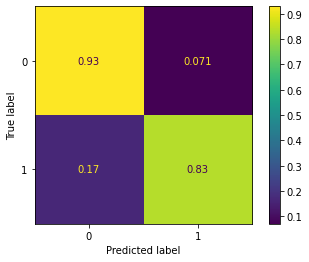

In [13]:
conf_matrix = confusion_matrix(y_test, y_predict, normalize='true')
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()